In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available
Using GPU: NVIDIA GeForce GTX 1070


In [3]:
BATCH_SIZE = 20
NUM_CLASSES = 43
IMAGE_SIZE = (224, 224)
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10


train_dir = "I:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "I:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "I:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [4]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=NUM_CLASSES)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

scaler = GradScaler()

def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for val_inputs, val_labels in valid_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        valid_losses.append(val_running_loss / len(valid_loader))
        valid_accs.append(100 * val_correct / val_total)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, '
              f'Train Acc: {train_accs[-1]:.2f}%, Val Loss: {valid_losses[-1]:.4f}, '
              f'Val Acc: {valid_accs[-1]:.2f}%')
        scheduler.step()

    return train_losses, valid_losses, train_accs, valid_accs

Loaded pretrained weights for efficientnet-b7


In [5]:
train_losses, valid_losses, train_accs, valid_accs = train_model(model, criterion, optimizer, scheduler)

Epoch 1/10, Train Loss: 0.2388, Train Acc: 95.18%, Val Loss: 0.0178, Val Acc: 99.59%


Epoch 2/10, Train Loss: 0.0077, Train Acc: 99.84%, Val Loss: 0.0273, Val Acc: 99.46%


Epoch 3/10, Train Loss: 0.0051, Train Acc: 99.88%, Val Loss: 0.0213, Val Acc: 99.52%


Epoch 4/10, Train Loss: 0.0029, Train Acc: 99.95%, Val Loss: 0.0233, Val Acc: 99.52%


Epoch 5/10, Train Loss: 0.0031, Train Acc: 99.93%, Val Loss: 0.0282, Val Acc: 99.52%


Epoch 6/10, Train Loss: 0.0010, Train Acc: 99.97%, Val Loss: 0.0215, Val Acc: 99.59%


Epoch 7/10, Train Loss: 0.0003, Train Acc: 99.99%, Val Loss: 0.0237, Val Acc: 99.61%


Epoch 8/10, Train Loss: 0.0003, Train Acc: 99.99%, Val Loss: 0.0240, Val Acc: 99.61%


Epoch 9/10, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.0236, Val Acc: 99.64%


Epoch 10/10, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.0219, Val Acc: 99.66%


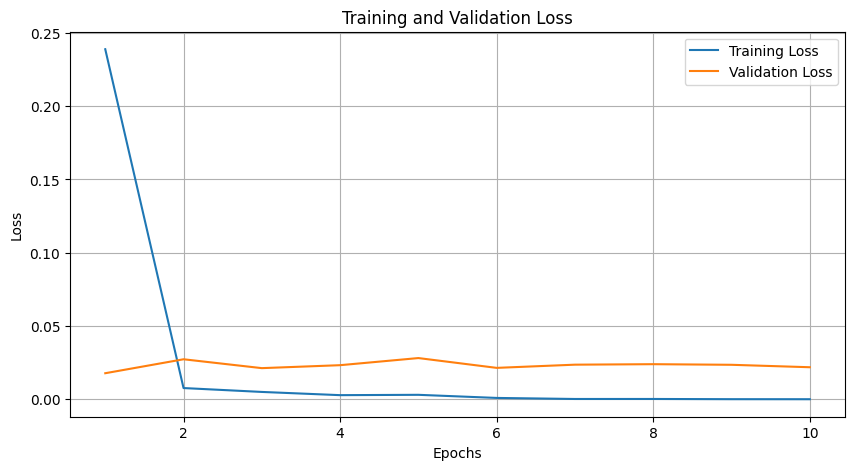

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

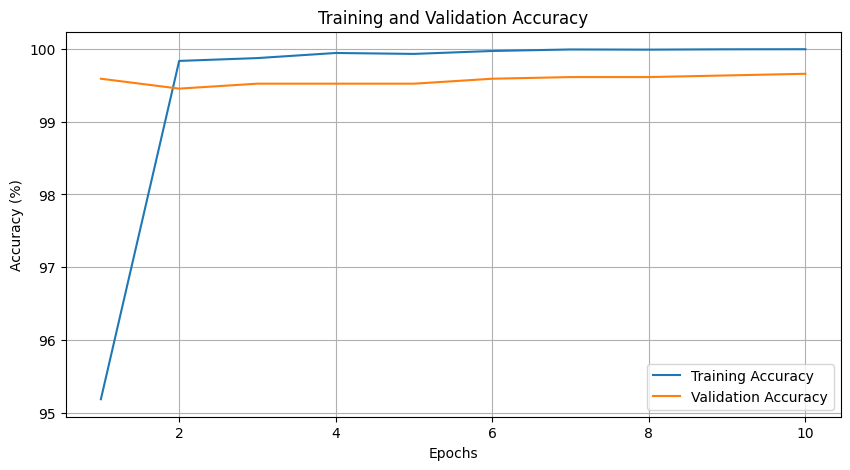

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), valid_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
label_names_path = 'G:/Datasets/Traffic Signs/label_names.csv'
label_names_df = pd.read_csv(label_names_path)
class_names = label_names_df['SignName'].tolist()

# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 632/632 [08:39<00:00,  1.22it/s]


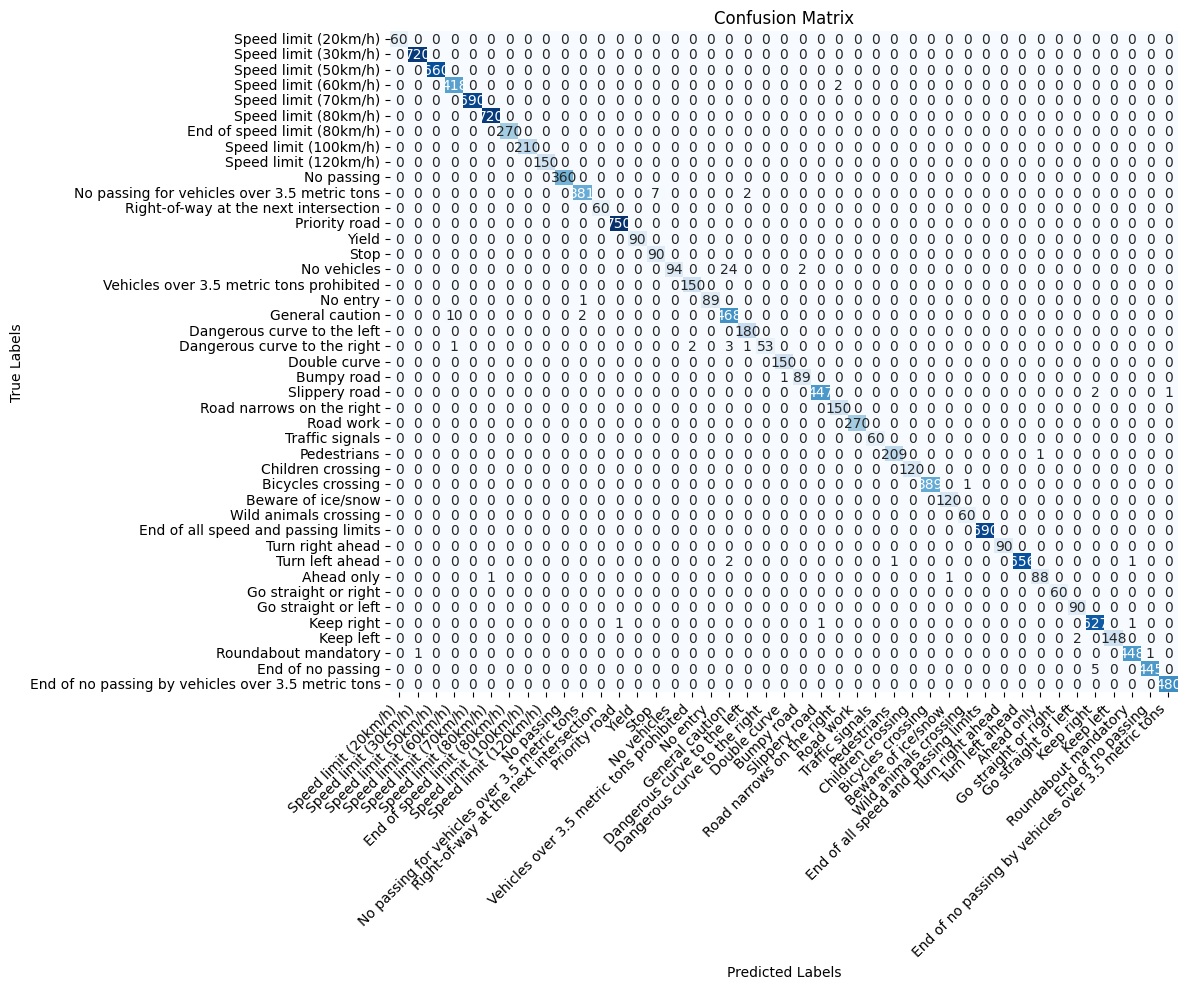

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       1.00      1.00      1.00       720
                              Speed limit (50km/h)       1.00      1.00      1.00       660
                              Speed limit (60km/h)       0.97      1.00      0.98       420
                              Speed limit (70km/h)       1.00      1.00      1.00       690
                              Speed limit (80km/h)       1.00      1.00      1.00       720
                       End of speed limit (80km/h)       1.00      1.00      1.00       270
                             Speed limit (100km/h)       1.00      1.00      1.00       210
                             Speed limit (120km/h)       1.00      1.00      1.00       150
                                        No passing       1.00      1.00      1.

In [12]:
#plot confusion matrix
cm, all_labels, all_preds = evaluate_model(model, test_loader)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))
print("Overall Accuracy:", accuracy_score(all_labels, all_preds))

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


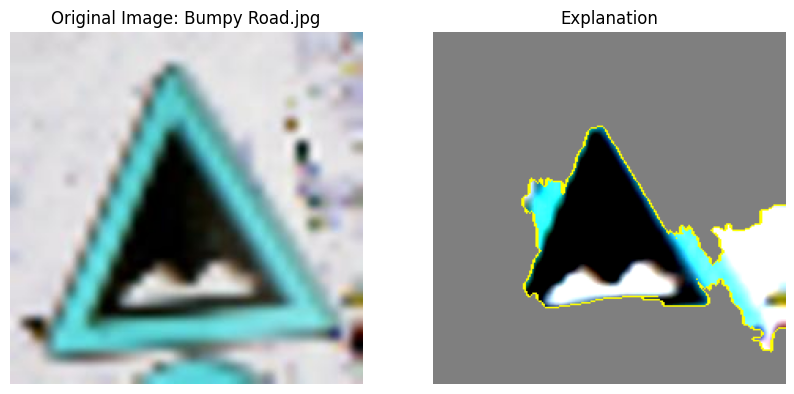

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


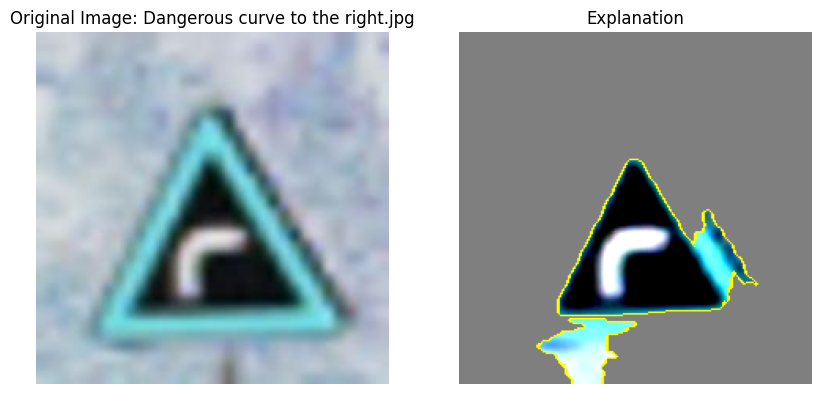

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


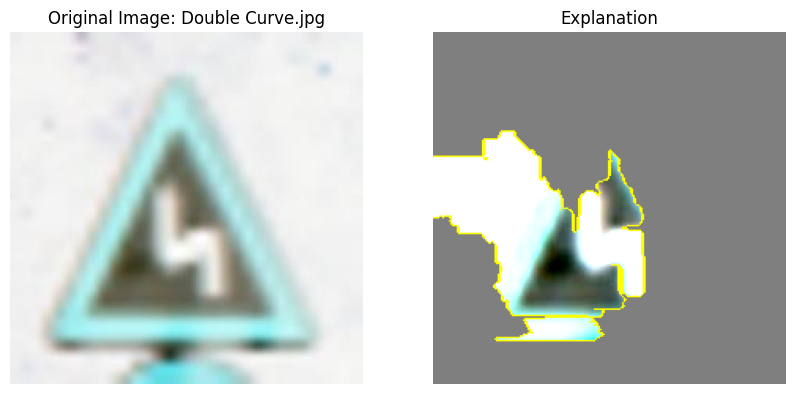

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


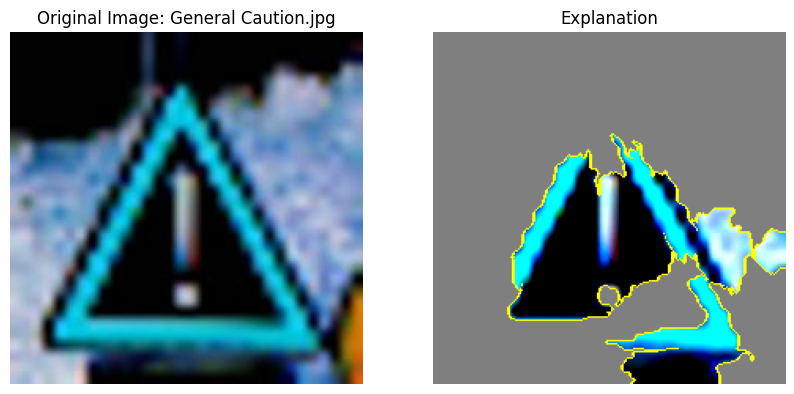

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


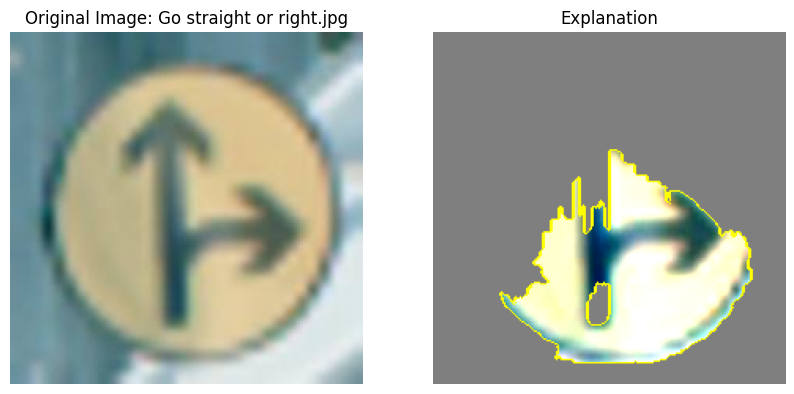

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


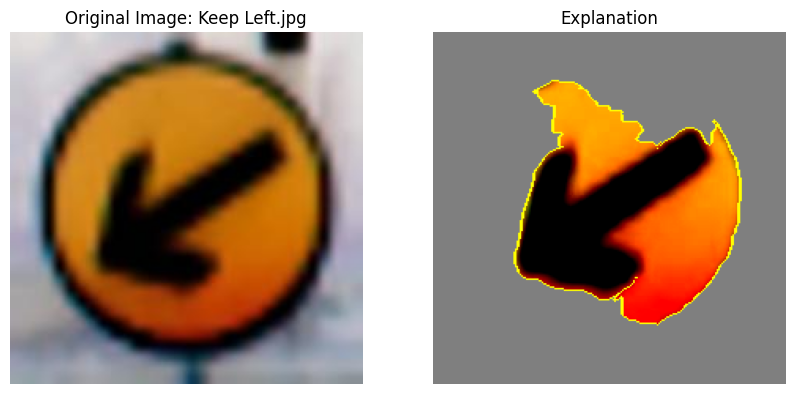

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


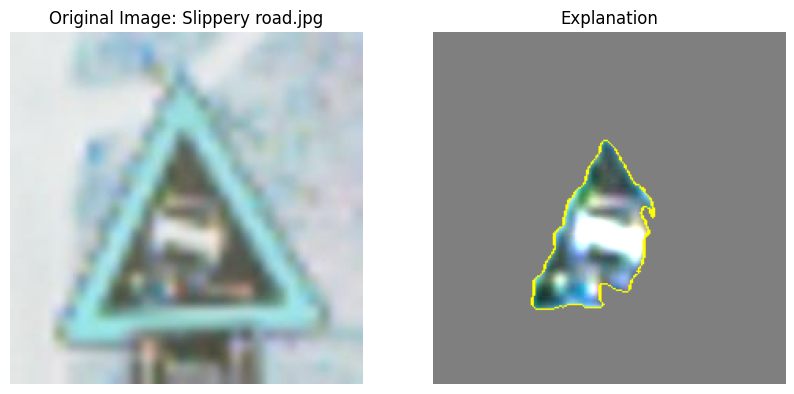

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


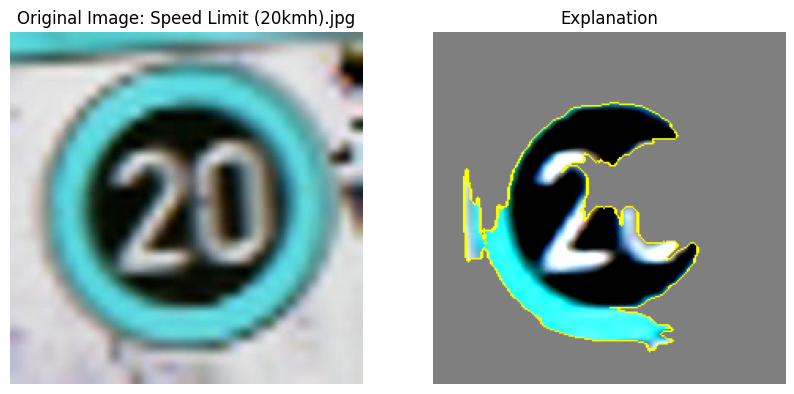

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


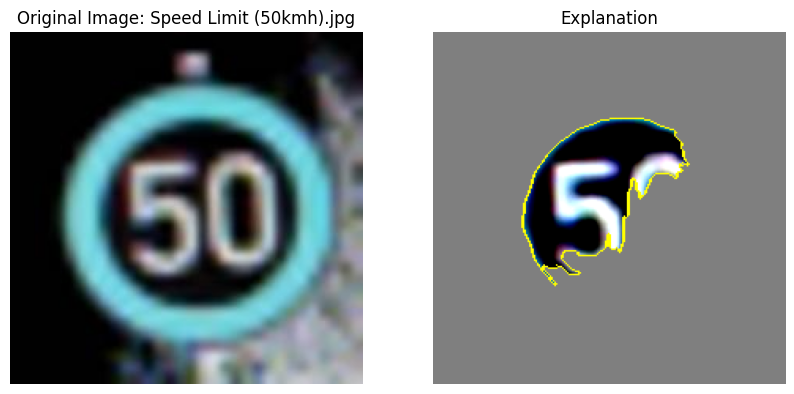

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


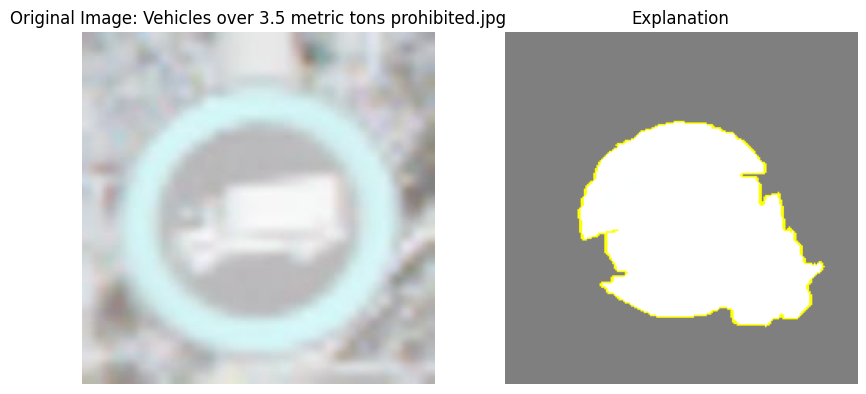

In [17]:
from lime import lime_image
import os
from PIL import Image
import numpy as np
from skimage.segmentation import mark_boundaries

xai_samples_dir = "I:/DATASET/XAI SAMPLES"
xai_samples = os.listdir(xai_samples_dir)

transform = data_transforms['test']

output_dir = "I:/DATASET/E7 XAI"  # Directory to save
os.makedirs(output_dir, exist_ok=True)

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

def generate_lime_explanations(model, image_path):
    explainer = lime_image.LimeImageExplainer()
    image = load_and_preprocess_image(image_path)
    
    def predict_fn(images):
        images = np.transpose(images, (0, 3, 1, 2))
        images = torch.tensor(images).float().to(device)
        # Forward pass
        outputs = model(images)
        return outputs.detach().cpu().numpy()
    
    explanation = explainer.explain_instance(np.transpose(image.numpy(), (1, 2, 0)), predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    
    return explanation

for image_name in xai_samples:
    image_path = os.path.join(xai_samples_dir, image_name)
    explanation = generate_lime_explanations(model, image_path)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    original_image = Image.open(image_path)
    plt.imshow(original_image)
    plt.title(f"Original Image: {image_name}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("Explanation")
    plt.axis('off')

    #save
    output_path = os.path.join(output_dir, f"explanation_{image_name}")
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()